Recommender systems: Content-based filtering

In this notebook, we will explore the fundamentals of recommendation systems, focusing specifically on content-based filtering techniques. We will delve into the workings of content-based filtering, a method that recommends items similar to those a user has liked or interacted with in the past.

In [1]:
# Import our regular old heroes
import numpy as np
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficiency.
import matplotlib.pyplot as plt
import seaborn as sns

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convenient item retrieval during iteration
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

In [2]:
A = np.array([[3,4]]) # <-- Rating vector A
B = np.array([[5,2]]) # <-- Rating vector B
cosine_similarity(A,B) # Sim(A,B)

array([[0.85419856]])

With an understanding of similarity out of the way, let's look at one more important concept before creating our own simple recommender systems - performance measurement!

In [3]:
anime = pd.read_csv('anime_cleaned.csv')
anime.head(3)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262


In [4]:
print (f'Number of anime in dataset: {anime.shape[0]}')

Number of anime in dataset: 12294


In [4]:
anime_ratings = pd.read_csv('train_cleaned.csv')
anime_ratings.head()

,user_id,anime_id,rating
0,1,11617.0,10.0
1,1,11757.0,10.0
2,1,15451.0,10.0
3,2,11771.0,10.0
4,3,20.0,8.0


In [7]:
print (f'Number of ratings in dataset: {anime_ratings.shape[0]}')

Number of ratings in dataset: 1171907


Let's look at the distribution of the ratings given by users. Here, we see that readers generally are on the kinder end of the rating spectrum, with a far higher proportion of positive reviews (> 3) being given over negative ones (< 3):

Average rating in dataset: 7.792661698122545


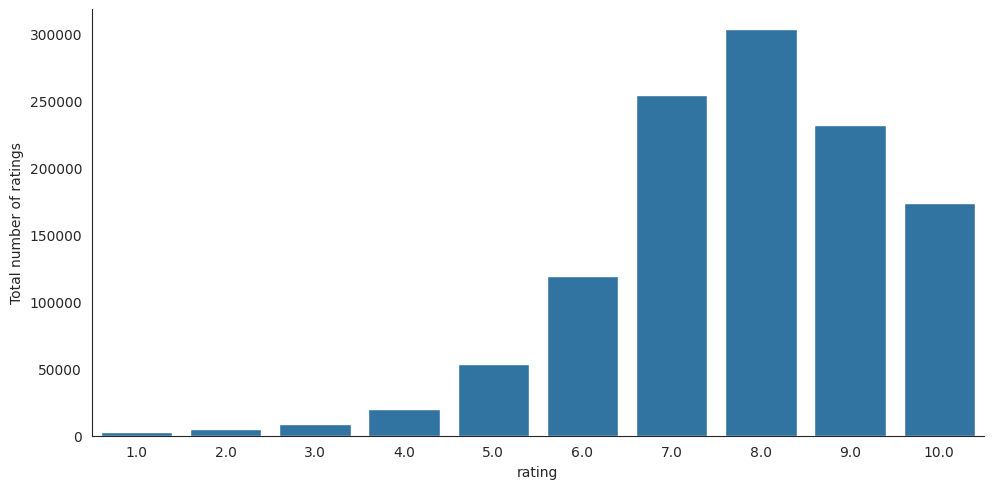

In [8]:
with sns.axes_style('white'):
    g = sns.catplot(data=anime_ratings, x="rating", y=None, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(anime_ratings["rating"])}')

That's enough spelunking through our data. Let’s go ahead and make a recommendation system.

The first step is generating recommendations using content-based filtering.

## Content-based filtering

### How it works

<br></br>

<div align="center" style="width: 800px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Content_filtering.jpg"
     alt="Content-based Filtering"
     style="float: center; padding-bottom=0.5em"
     width=800px/>
A depiction of the decision process used to recommend items within content-based filtering algorithms.  
</div>

In Content-based filtering, we seek to make recommendations based on **how similar an item's properties or features are to those of other items.**

So let's see how we would implement a system like this in real life.

### Implementation

Let's implement a straightforward content filtering-based recommendation algorithm.

To begin, we need to gather the various properties of our items so that we can convert them into meaningful features. Following along from our example above, we're going to use the `tag_name` field for each book as a representation of properties such as genre, time-period, and target audience. We're also going to consider the `authors` field, as individuals often enjoy reading novels written by the same author.

We start off by creating a new column in our `books` dataframe called `auth_tags`, which contains the above-motivated contents for each item. We additionally create two pandas series objects to help us translate between book titles and indexes of our dataframe.  

In [5]:
# Combine 'name' and 'genre' into a single string for each anime
anime['name_genre'] = (pd.Series(anime[['name', 'genre']]
                      .fillna('')
                      .values.tolist()).str.join(' '))

# Convenient indexes to map between anime titles and indexes of the merged_df dataframe
titles = anime['name']
indices = pd.Series(anime.index, index=anime['name'])


We now need a mechanism to convert these textual features into a format that enables us to compute their relative similarities. This will allow us to translate our string-based collection of tags and authors into numerical vectors (see [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for an overview of this process which is very similar to [count-based vectorization](https://youtu.be/W9VtEVBdgnQ)).

In [6]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0.0, stop_words='english')

# Produce a feature matrix, where each row corresponds to an anime,
# with TF-IDF features as columns
tf_namgen_matrix = tf.fit_transform(anime['name_genre'])

We can now compute the similarity between each vector within our matrix. This is done by making use of the `cosine_similarity` function provided to us by `sklearn`.

In [7]:
cosine_sim_namgen = cosine_similarity(tf_namgen_matrix,
                                        tf_namgen_matrix)
print (cosine_sim_namgen.shape)

(12294, 12294)


In [8]:
cosine_sim_namgen[:5]

array([[1.        , 0.01320774, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01320774, 1.        , 0.02488704, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02488704, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.05289645, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02280114, 0.74799921, ..., 0.        , 0.        ,
        0.        ]])

#### Top-N recommendations

With our content similarity matrix computed, we're now ready to make some recommendations! Let's begin by generating a top-N list of animes similar to the one which we prompt the system with.    

Following along from our earlier algorithmic explanation, we do this by:

  1. Select an initial item (anime) from which to generate recommendations.
  2. Extract all the similarity values between the initial item and each other item in the similarity matrix.
  3. Sort the resulting values in descending order.
  4. Select the top N similarity values and return the corresponding item details to the user. This is now our simple top-N list.  
  
We implement this algorithmic process in the function below:

In [9]:
def content_generate_top_N_recommendations(anime_title, N=10):
    # Convert the string anime title to a numeric index for our similarity matrix
    a_idx = indices[anime_title]

    # Extract all similarity values computed with the reference anime title
    sim_scores = list(enumerate(cosine_sim_namgen[a_idx]))

    # Sort the values, keeping a copy of the original index of each value
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Select the top-N values for recommendation
    sim_scores = sim_scores[1:N+1]  # Include N recommendations

    # Collect indexes
    anime_indices = [i[0] for i in sim_scores]

    # Convert the indexes back into titles
    return titles.iloc[anime_indices]



In [10]:
# Example usage
recommended_animes = content_generate_top_N_recommendations('Shingeki no Kyojin', N=10)
print(recommended_animes)

717                            Shingeki no Kyojin OVA
10899                     Shingeki no Kyojin Season 2
3533                  Shingeki no Kyojin: Ano Hi Kara
961      Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa
1069      Shingeki no Kyojin Movie 1: Guren no Yumiya
74                                          One Piece
4090                 Shingeki no Kyojin Picture Drama
3185                      Shingeki! Kyojin Chuugakkou
2492                                One Piece Movie 1
1399                                                X
Name: name, dtype: object


With our function defined, let's test our simple content-based recommender on some sample anime titles:

In [11]:
content_generate_top_N_recommendations("Fullmetal Alchemist: Brotherhood", N=10)

402             Fullmetal Alchemist: Brotherhood Specials
200                                   Fullmetal Alchemist
1558        Fullmetal Alchemist: The Sacred Star of Milos
1030    Fullmetal Alchemist: Brotherhood - 4-Koma Theater
1967                     Fullmetal Alchemist: Reflections
971       Fullmetal Alchemist: The Conqueror of Shamballa
2397    Fullmetal Alchemist: The Sacred Star of Milos ...
1742              Fullmetal Alchemist: Premium Collection
5709                                                Arion
879                   Tales of Vesperia: The First Strike
Name: name, dtype: object

---
#### Rating Prediction

As motivated previously, in some cases, we may wish to calculate directly what rating a user _would_ give a book that they haven't read yet.

We can modify our content-based filtering algorithm to do this in the following manner:

   1. Select a reference user from the database and a reference item (book) they have _not_ rated.
   2. For the user, gather the similarity values between the reference item and each item the user _has_ rated.
   3. Sort the gathered similarity values in descending order.
   4. Select the $k$ highest similarity values, which are above a given threshold value, creating a collection $K$.
   5. Compute a weighted average rating from these values, which is the sum of the similarity values of each item multiplied by its assigned user rating, divided by the sum of the similarity values. This can be expressed in the formula as:
   
   $$ \hat{R}_{ju} = \frac{\sum_{i \in K} s_{ij} \times r_{iu}}{\sum_{i \in K} s_{ij}}   $$
   
   where $\hat{R}_{ju}$ is the weighted average computed for the reference item $j$ and reference user $u$, $K$ is the collection of items, $s_{ij}$ is the similarity computed between items $i$ and $j$, and $r_{iu}$ is the known rating user $u$ has given item $i$.
   6. We return the weighted average $\hat{R}_{ju}$ as the prediction for our reference item.
   
   
We implement this algorithmic process in the function below:

In [18]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357242 sha256=76064e1081f946fe3430bd5814675edcc59b0a324cbcbf9961841d367ef339ab
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [20]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Define the reader with the rating scale
reader = Reader(rating_scale=(anime_ratings['rating'].min(), anime_ratings['rating'].max()))

# Load the data into the Surprise dataset
data = Dataset.load_from_df(anime_ratings[['user_id', 'anime_id', 'rating']], reader)

# Split the data into training and test sets
trainset, _ = train_test_split(data, test_size=0.25, random_state=42)

# Define the SVD model
model = SVD()

# Train the model
model.fit(trainset)





In [35]:
# Load your dataset
test_data = pd.read_csv('test_cleaned.csv')

In [36]:
test_data.shape

(633686, 2)

In [37]:
# Function to predict ratings for test data
def generate_submission(test_data, model):
    predictions = []
    for row in test_data.itertuples(index=False):
        user_id, anime_id = row.user_id, row.anime_id
        pred = model.predict(user_id, anime_id).est
        predictions.append((f"{user_id}_{anime_id}", pred))

    # Create the submission DataFrame
    submission = pd.DataFrame(predictions, columns=['ID', 'rating'])
    # Ensure the number of rows matches the test set
    assert len(submission) == len(test_data), f"Submission must have {len(test_data)} rows, but has {len(submission)} rows."

    return submission



In [38]:
# Generate predictions for the test data
submission = generate_submission(test_data, model)

In [39]:
# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully.")


Submission file created successfully.


In [40]:
submission.shape

(633686, 2)

In [41]:
submission.head()

,ID,rating
0,40763_21405,10.0
1,68791_10504,10.0
2,40487_1281,10.0
3,55290_165,10.0
4,72323_11111,10.0


With our algorithm defined, let's quickly test it out to see some results.

To help us get a sense of the relevance and accuracy of these ratings, we select a lucky user (number 150) and consider their historical data:

In [13]:
# Subset of ratings from user 150
anime_ratings[anime_ratings['user_id'] == 150][3:10]

,user_id,anime_id,rating
8377,150,9919.0,10.0


## Conclusion

We covered a lot of ground in this train by identifying the building blocks of recommender systems: items (things) and users (people). We've learned how recommender algorithms fundamentally use similarity to compare these items and users, with item-item similarity represented by the content-based filtering method. We went on to review the content-based filtering method both theoretically and practically through code implementation.